# Strong Scaling

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
df = pd.read_csv("results.csv", parse_dates=["datetime"])

df["total_time"] = df["gen_time"] + df["dist_time"]

counts = df.groupby(["device", "power", "num_procs"]).size()
print("Número de execuções por configuração:")
print(counts)

FileNotFoundError: [Errno 2] No such file or directory: 'results.csv'

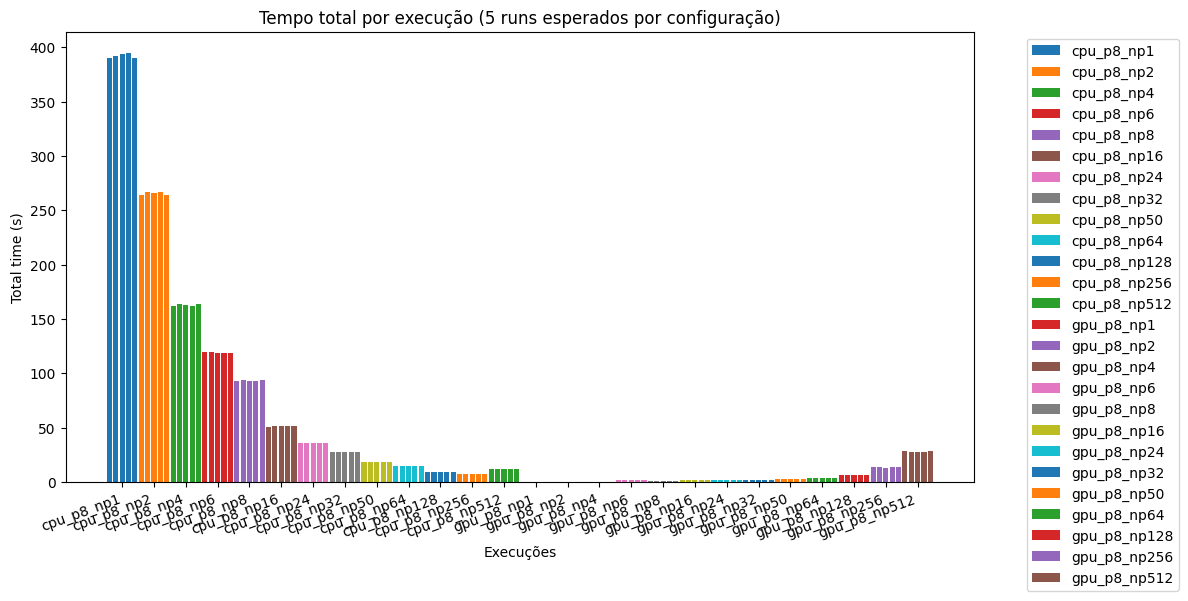

In [ ]:
plt.figure(figsize=(12, 6))

# cores diferentes para cada configuração
for i, (key, group) in enumerate(df.groupby(["device", "power", "num_procs"])):
    label = f"{key[0]}_p{key[1]}_np{key[2]}"
    x = [f"run{j+1}" for j in range(len(group))]  # rótulos curtos no eixo x
    xpos = range(i*len(group), (i+1)*len(group))  # posição sequencial no eixo
    plt.bar(xpos, group["total_time"], label=label)

plt.ylabel("Total time (s)")
plt.xlabel("Execuções")
plt.title("Tempo total por execução (5 runs esperados por configuração)")

# Coloca ticks agrupados e mais legíveis
tick_positions = []
tick_labels = []
for i, (key, group) in enumerate(df.groupby(["device", "power", "num_procs"])):
    center = i*len(group) + len(group)/2 - 0.5
    tick_positions.append(center)
    tick_labels.append(f"{key[0]}_p{key[1]}_np{key[2]}")

plt.xticks(tick_positions, tick_labels, rotation=20, ha="right")

# legenda fora do gráfico
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

In [ ]:
summary = (
    df.groupby(["device", "power", "num_procs"])
      .agg(
          gen_mean=("gen_time", "mean"),
          gen_std=("gen_time", "std"),
          dist_mean=("dist_time", "mean"),
          dist_std=("dist_time", "std"),
          total_mean=("total_time", "mean"),
          total_std=("total_time", "std"),
          runs=("total_time", "count")
      )
      .reset_index()
)

print("\nResumo por configuração (agrupado por device, power e num_procs):")
print(summary)



Resumo por configuração (agrupado por device, power e num_procs):
   device  power  num_procs    gen_mean   gen_std  dist_mean  dist_std  \
0     cpu      8          1  377.943126  1.990381  14.147310  0.141898   
1     cpu      8          2  254.702263  1.363902  10.748582  0.045571   
2     cpu      8          4  155.798717  0.682053   7.120726  0.027917   
3     cpu      8          6  114.144755  0.531584   4.895305  0.028144   
4     cpu      8          8   89.523910  0.292315   3.892847  0.037917   
5     cpu      8         16   49.022490  0.086147   2.157309  0.009991   
6     cpu      8         24   33.979804  0.127555   1.793389  0.008879   
7     cpu      8         32   26.054772  0.095298   1.472783  0.005566   
8     cpu      8         50   17.246634  0.033474   1.036854  0.001934   
9     cpu      8         64   13.720948  0.081332   0.938254  0.014563   
10    cpu      8        128    8.237666  0.026923   0.609947  0.003400   
11    cpu      8        256    4.305437  0.01

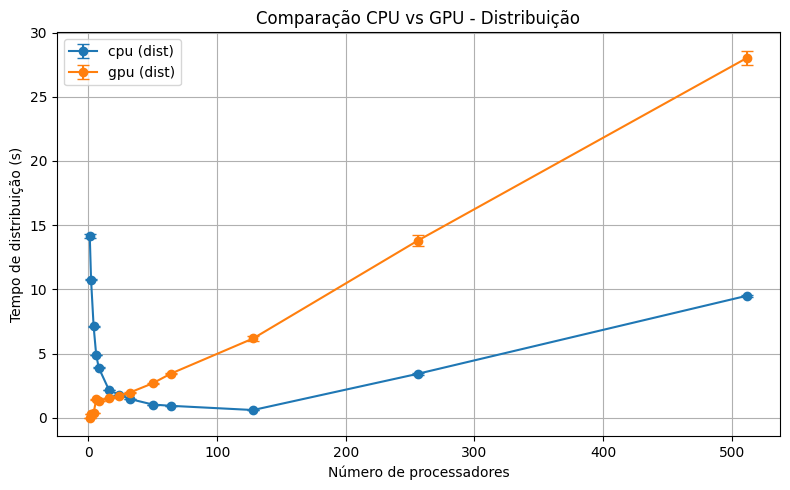

In [ ]:

plt.figure(figsize=(8, 5))
for dev in summary["device"].unique():
    subset = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(
        subset["num_procs"], subset["dist_mean"],
        yerr=subset["dist_std"],
        marker="o", capsize=4, label=f"{dev} (dist)"
    )

plt.xlabel("Número de processadores")
plt.ylabel("Tempo de distribuição (s)")
plt.title("Comparação CPU vs GPU - Distribuição")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

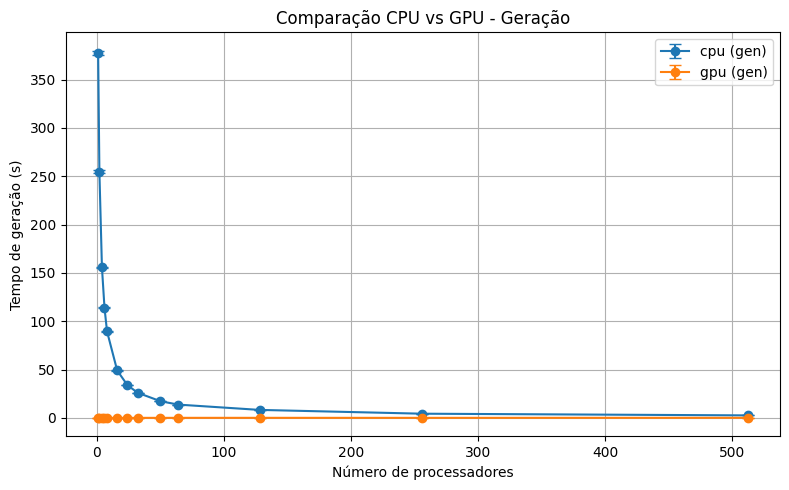

In [ ]:
plt.figure(figsize=(8, 5))
for dev in summary["device"].unique():
    subset = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(
        subset["num_procs"], subset["gen_mean"],
        yerr=subset["gen_std"],
        marker="o", capsize=4, label=f"{dev} (gen)"
    )

plt.xlabel("Número de processadores")
plt.ylabel("Tempo de geração (s)")
plt.title("Comparação CPU vs GPU - Geração")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


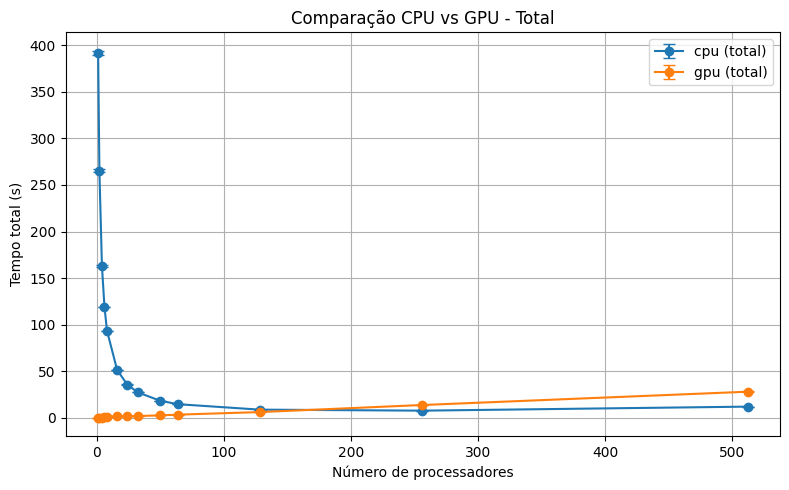

In [ ]:
plt.figure(figsize=(8, 5))
for dev in summary["device"].unique():
    subset = summary[summary["device"] == dev].sort_values("num_procs")
    plt.errorbar(
        subset["num_procs"], subset["total_mean"],
        yerr=subset["total_std"],
        marker="o", capsize=4, label=f"{dev} (total)"
    )

plt.xlabel("Número de processadores")
plt.ylabel("Tempo total (s)")
plt.title("Comparação CPU vs GPU - Total")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Speedup (baseline = CPU por 'power'):
   device  power  num_procs  cpu_base_nprocs    speedup_gen  speedup_gen_s  \
0     cpu      8          1                1       1.000000       0.007448   
1     cpu      8          2                1       1.483862       0.011145   
2     cpu      8          4                1       2.425842       0.016613   
3     cpu      8          6                1       3.311086       0.023277   
4     cpu      8          8                1       4.221700       0.026160   
5     cpu      8         16                1       7.709586       0.042802   
6     cpu      8         24                1      11.122581       0.071933   
7     cpu      8         32                1      14.505716       0.093009   
8     cpu      8         50                1      21.914023       0.122995   
9     cpu      8         64                1      27.544972       0.218407   
10    cpu      8        128                1      45.879878       0.284367   
11    cpu      8        2

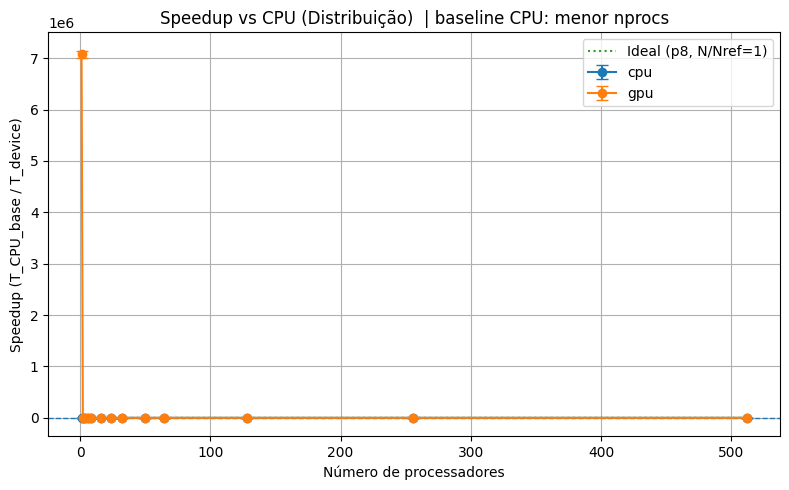

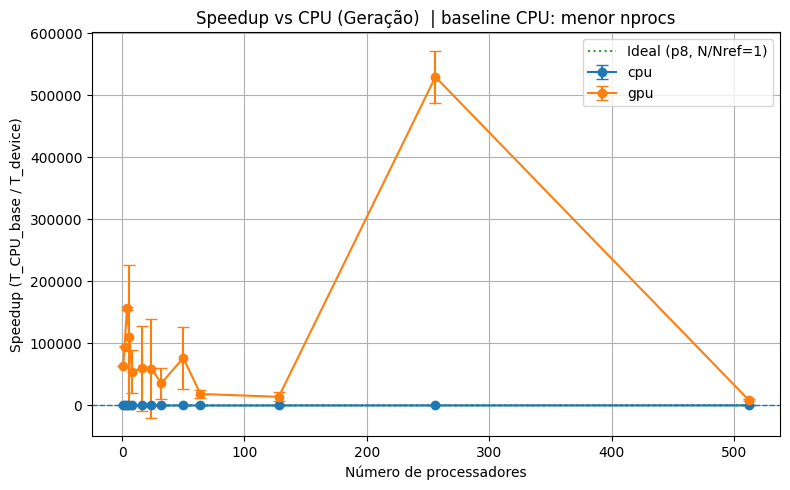

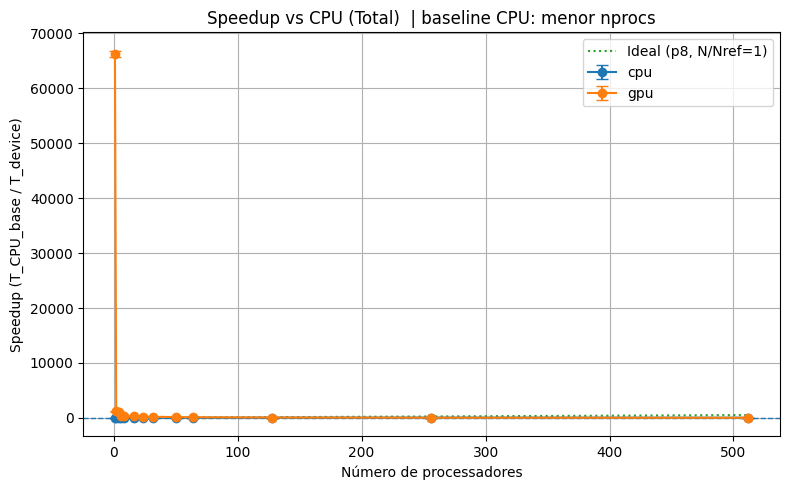

In [28]:
# Escolha do baseline: None => usa o menor num_procs de CPU por 'power'
BASELINE_NPROCS = None  # ex.: 1 para forçar CPU-1; ou deixe None

# summary já existe do seu código anterior
# columns: device, power, num_procs, gen_mean, gen_std, dist_mean, dist_std, total_mean, total_std, runs

# --- Seleciona baseline CPU por 'power' ---
cpu_only = summary[summary["device"] == "cpu"].copy()

if BASELINE_NPROCS is None:
    # menor num_procs por power
    cpu_base = (cpu_only.sort_values(["power", "num_procs"])
                        .groupby("power", as_index=False)
                        .first())
else:
    # força baseline num_procs específico
    cpu_base = cpu_only[cpu_only["num_procs"] == BASELINE_NPROCS].copy()
    if cpu_base.empty:
        raise ValueError(f"Não há baseline CPU com num_procs={BASELINE_NPROCS}.")

cpu_base = cpu_base[[
    "power", "num_procs",
    "gen_mean", "gen_std",
    "dist_mean", "dist_std",
    "total_mean", "total_std"
]].rename(columns={
    "num_procs": "cpu_base_nprocs",
    "gen_mean": "gen_cpu",
    "gen_std": "gen_cpu_std",
    "dist_mean": "dist_cpu",
    "dist_std": "dist_cpu_std",
    "total_mean": "total_cpu",
    "total_std": "total_cpu_std",
})

# --- Anexa baseline a todas as linhas com o mesmo 'power' ---
with_base = summary.merge(cpu_base, on="power", how="inner")

# --- Speedup = T_CPU_base / T_device ---
def ratio(a, b):
    return np.where((b > 0) & np.isfinite(b), a / b, np.nan)

# Propagação aproximada do desvio (σ_{A/B} ≈ (A/B)*sqrt((σA/A)^2 + (σB/B)^2))
def ratio_std(a, sa, b, sb):
    s = ratio(a, b)
    term = np.zeros_like(s, dtype=float)
    good = (a > 0) & (b > 0) & np.isfinite(a) & np.isfinite(b)
    term[good] = np.sqrt( (sa[good]/a[good])**2 + (sb[good]/b[good])**2 )
    out = np.full_like(s, np.nan, dtype=float)
    out[good] = s[good] * term[good]
    return out

with_base["speedup_dist"]  = ratio(with_base["dist_cpu"],  with_base["dist_mean"])
with_base["speedup_dist_s"] = ratio_std(with_base["dist_cpu"], with_base["dist_cpu_std"],
                                        with_base["dist_mean"], with_base["dist_std"])

with_base["speedup_gen"]   = ratio(with_base["gen_cpu"],   with_base["gen_mean"])
with_base["speedup_gen_s"]  = ratio_std(with_base["gen_cpu"],  with_base["gen_cpu_std"],
                                        with_base["gen_mean"],  with_base["gen_std"])

with_base["speedup_total"] = ratio(with_base["total_cpu"], with_base["total_mean"])
with_base["speedup_total_s"] = ratio_std(with_base["total_cpu"], with_base["total_cpu_std"],
                                         with_base["total_mean"], with_base["total_std"])

# --- Tabela de speedup por (device, power, num_procs) ---
cols_show = [
    "device", "power", "num_procs", "cpu_base_nprocs",
    "speedup_gen", "speedup_gen_s",
    "speedup_dist", "speedup_dist_s",
    "speedup_total", "speedup_total_s",
    "runs"
]
print("\nSpeedup (baseline = CPU por 'power'):")
print(with_base[cols_show].sort_values(["power", "device", "num_procs"]))

# --- Gráficos de speedup (CPU vs GPU) por número de processadores ---
def plot_speedup(df_speed, y, yerr, title):
    plt.figure(figsize=(8,5))

    # Curvas de speedup por device
    for dev in df_speed["device"].unique():
        sub = df_speed[df_speed["device"] == dev].sort_values("num_procs")
        plt.errorbar(sub["num_procs"], sub[y], yerr=sub[yerr],
                     marker="o", capsize=4, label=dev)

    # Linha horizontal = "igual ao baseline" (S=1)
    plt.axhline(1.0, linestyle="--", linewidth=1)

    # Linha(s) de strong scaling ideal: S_ideal = num_procs / cpu_base_nprocs
    # (uma por 'power', pois cpu_base_nprocs depende do power)
    for pw in sorted(df_speed["power"].unique()):
        g = df_speed[df_speed["power"] == pw]
        if g.empty: 
            continue
        nref = g["cpu_base_nprocs"].iloc[0]  # mesmo nref para esse 'power'
        xs = sorted(g["num_procs"].unique())
        ys = [x / nref for x in xs]
        plt.plot(xs, ys, linestyle=":", linewidth=1.5,
                 label=f"Ideal (p{pw}, N/Nref={nref})")

    plt.xlabel("Número de processadores")
    plt.ylabel("Speedup (T_CPU_base / T_device)")
    plt.title(title + (f"  | baseline CPU: nprocs={BASELINE_NPROCS}" if BASELINE_NPROCS is not None else "  | baseline CPU: menor nprocs"))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_speedup(with_base, "speedup_dist",  "speedup_dist_s",  "Speedup vs CPU (Distribuição)")
plot_speedup(with_base, "speedup_gen",   "speedup_gen_s",   "Speedup vs CPU (Geração)")
plot_speedup(with_base, "speedup_total", "speedup_total_s", "Speedup vs CPU (Total)")

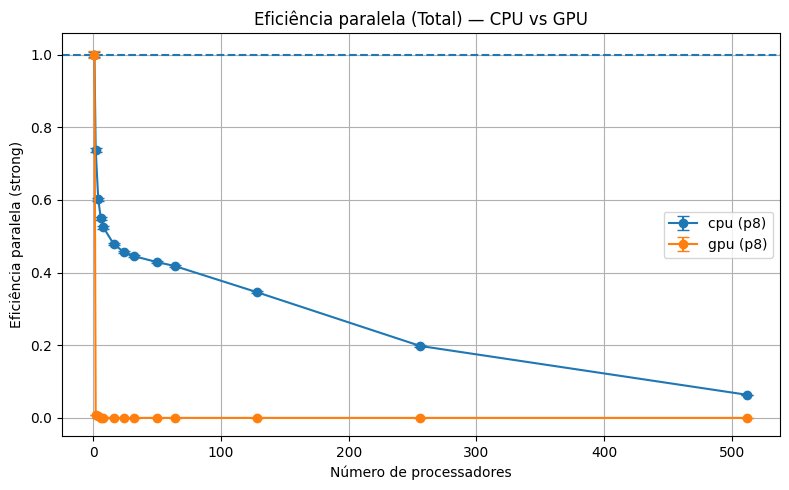

In [26]:
ref = (summary.sort_values(["device", "power", "num_procs"])
              .groupby(["device", "power"], as_index=False)
              .first())

ref = ref[["device","power","num_procs","total_mean","total_std"]].rename(columns={
    "num_procs": "n_ref",
    "total_mean": "t_ref",
    "total_std": "s_ref",
})

eff = summary.merge(ref, on=["device","power"], how="inner")

# Eficiência: E = (t_ref * n_ref) / (total_mean * num_procs)
eff["eff_strong"] = (eff["t_ref"] * eff["n_ref"]) / (eff["total_mean"] * eff["num_procs"])

# Desvio de E por propagação (n_ref e num_procs são constantes, ignoram desvio):
# σ_E ≈ E * sqrt( (σ_ref/t_ref)^2 + (σ_N/t_N)^2 )
good = (eff["t_ref"]>0) & (eff["total_mean"]>0) & np.isfinite(eff["t_ref"]) & np.isfinite(eff["total_mean"])
eff["eff_strong_s"] = np.nan
eff.loc[good, "eff_strong_s"] = (
    eff.loc[good, "eff_strong"] *
    np.sqrt( (eff.loc[good,"s_ref"]/eff.loc[good,"t_ref"])**2 +
             (eff.loc[good,"total_std"]/eff.loc[good,"total_mean"])**2 )
)

# Gráfico: eficiência vs num_procs, linhas separadas por device (e power)
plt.figure(figsize=(8,5))
for (dev, pw), g in eff.sort_values("num_procs").groupby(["device","power"]):
    plt.errorbar(g["num_procs"], g["eff_strong"], yerr=g["eff_strong_s"],
                 marker="o", capsize=4, label=f"{dev} (p{pw})")

plt.axhline(1.0, linestyle="--")  # ideal
plt.xlabel("Número de processadores")
plt.ylabel("Eficiência paralela (strong)")
plt.title("Eficiência paralela (Total) — CPU vs GPU")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

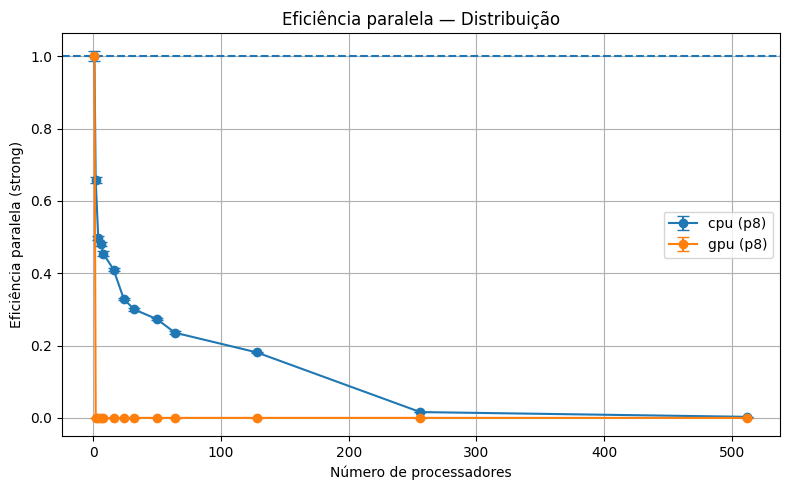

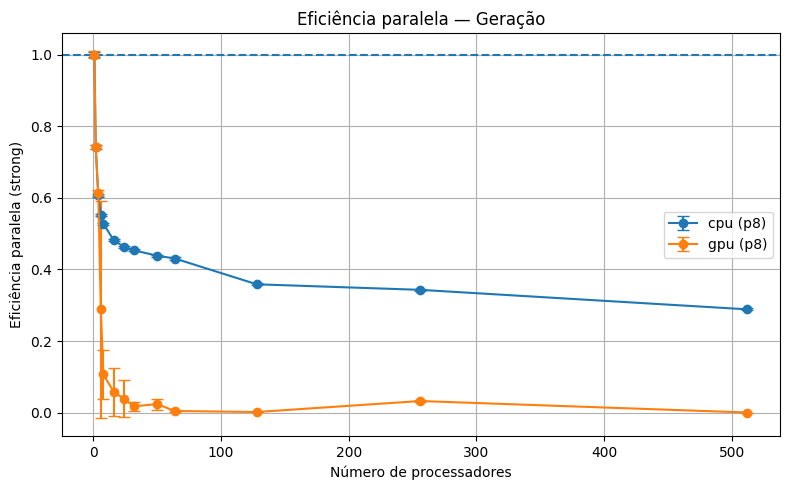

In [27]:
def plot_eff(summary, mean_col, std_col, title_suffix):
    ref = (summary.sort_values(["device", "power", "num_procs"])
                  .groupby(["device","power"], as_index=False)
                  .first())
    ref = ref[["device","power","num_procs",mean_col,std_col]].rename(columns={
        "num_procs": "n_ref", mean_col: "t_ref", std_col: "s_ref"
    })
    e2 = summary.merge(ref, on=["device","power"], how="inner")
    e2["eff"] = (e2["t_ref"] * e2["n_ref"]) / (e2[mean_col] * e2["num_procs"])
    good = (e2["t_ref"]>0) & (e2[mean_col]>0) & np.isfinite(e2["t_ref"]) & np.isfinite(e2[mean_col])
    e2["eff_s"] = np.nan
    e2.loc[good,"eff_s"] = e2.loc[good,"eff"] * np.sqrt(
        (e2.loc[good,"s_ref"]/e2.loc[good,"t_ref"])**2 + (e2.loc[good,std_col]/e2.loc[good,mean_col])**2
    )
    plt.figure(figsize=(8,5))
    for (dev, pw), g in e2.sort_values("num_procs").groupby(["device","power"]):
        plt.errorbar(g["num_procs"], g["eff"], yerr=g["eff_s"], marker="o", capsize=4, label=f"{dev} (p{pw})")
    plt.axhline(1.0, linestyle="--")
    plt.xlabel("Número de processadores")
    plt.ylabel("Eficiência paralela (strong)")
    plt.title(f"Eficiência paralela — {title_suffix}")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# Exemplo de uso:
plot_eff(summary, "dist_mean", "dist_std", "Distribuição")
plot_eff(summary, "gen_mean",  "gen_std",  "Geração")

